I first import the modules needed into the program

In [ ]:
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

I then set my Microsoft Azure Key so that I can run free multi image searches for 150 images at a time.

I test that this was done correctly by running a search and seeing if I get any results back 

In [ ]:
key = '6329058c6d97448fad14c0c3772b43e0'
results = search_images_bing(key, 'yoga')
ims=results.attrgot('contentUrl')
len(ims)

150

I create a folder in which to save the images, I then read from the folder to test that the image is correct

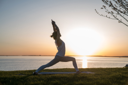

In [ ]:
dest = 'images/yoga.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

I create a list of the different types of yoga I want to identify and set a path for them to save into. 

In [ ]:
yoga_moves = 'warrior', 'down dog', 'Mountain'
path = Path('Yoga')

This loop runs through the list of types and for each item in the list it runs a bing image search to download 150 images of that type with the word "yoga" after it.

The images are then saved in their own folder. 

In [ ]:
if not path.exists():
    path.mkdir()
    for o in yoga_moves:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} yoga')
        download_images(dest, urls=results.attrgot('contentUrl'))

Checks that there are images saved in the folder

In [ ]:
fns = get_image_files(path)
fns

(#412) [Path('Yoga/down dog/00000047.jpg'),Path('Yoga/down dog/00000055.jpg'),Path('Yoga/down dog/00000011.png'),Path('Yoga/down dog/00000107.jpg'),Path('Yoga/down dog/00000036.jpg'),Path('Yoga/down dog/00000097.jpg'),Path('Yoga/down dog/00000110.jpg'),Path('Yoga/down dog/00000029.jpg'),Path('Yoga/down dog/00000091.jpg'),Path('Yoga/down dog/00000093.jpg')...]

Check to see if any of the images downloaded are corrupt 

In [ ]:
failed = verify_images(fns)
failed

(#0) []

Delete any of the images if they are corrupt 

In [ ]:
failed.map(Path.unlink);

Creates a Data Block file type that creates 2 blocks of data, one with the images and another with the categroy it belongs to.

The images are then collected and split randomly as a training set by which to train the neural network and as a test set to see if the neural network is correct once complete. 80% of images will be the training set while 20% will be the test set.

All of the images are the resized to all be the same dimensions to make it easier for training.

In [ ]:
YogaPos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Checks that the images are in the corrct category and displays them 

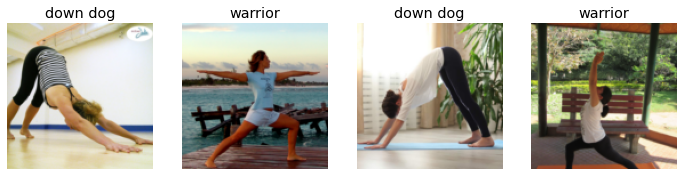

In [ ]:
dls = YogaPos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Randomly crops the images and transfors them so that the model can see images from different views etc.

In [ ]:
YogaPos = YogaPos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = YogaPos.dataloaders(path)



Begins and trains a neural network. The neural netwrk uses resnet 18 as a base for identifying images, it then retrains this already created nural netwrok for 4 epochs on the images and classifying that we want it to.

We then test the model against the test set which is the matrix seen below. We can see thewre were a few errors between the classification of mountain and warrior but other than that is did quite well. 

epoch,train_loss,valid_loss,error_rate,time
0,1.868044,1.198614,0.402439,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.814089,0.631025,0.243902,00:10
1,0.629853,0.479327,0.158537,00:09
2,0.503275,0.473985,0.146341,00:10
3,0.429070,0.461708,0.121951,00:10


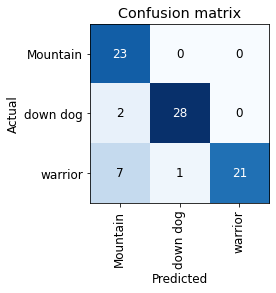

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Shows images where the model messed up 

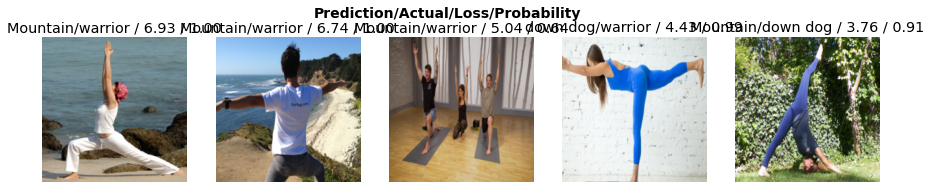

In [ ]:
interp.plot_top_losses(5, nrows=1)

Exports the Neural Net as a program that can be uploaded to a server or used etc. with use of a inference learner  

In [ ]:
learn.export()

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner
